In [8]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import time

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import yaml

from sklearn.model_selection import train_test_split

pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', None)


In [2]:
## In tthis section we will handle the following tasks
## Missing values treatment
## Temporal variables
## Non-Gaussian distributed variables
## Categorical varibales: treating rare labels
## Categorical variables: convert strings to numbers
## Standardizing the values to same range


## NOTE: IT IS ABSOLUTELY NECESSARY TO SET THE SEED FOR REPRODUCIBILITY

In [4]:
with open('config.yaml', 'r') as f:
    config = yaml.load(f)

print(config)

{'PATH': {'PROJECT_PATH': 'D:\\Kaggle\\MachineLearning_CI_CD', 'SCRIPT_PATH': 'D:\\Kaggle\\MachineLearning_CI_CD\\scripts', 'MODELS_PATH': 'D:\\Kaggle\\MachineLearning_CI_CD\\models', 'DATA_PATH': 'D:\\Kaggle\\MachineLearning_CI_CD\\data', 'ANALYSIS_REPORTS_PATH': 'D:\\Kaggle\\MachineLearning_CI_CD\\documents\\Analysis\\'}}


In [10]:
train = pd.read_csv(os.path.join(config['PATH']['DATA_PATH'], 'train.csv'))
train.head()
train.shape

(1460, 81)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train, train['SalePrice'], test_size = 0.1, random_state = 0)

X_train.shape, X_test.shape

((1314, 81), (146, 81))

In [11]:
## Treating missing values: Categorical variables
vars_with_na = [var for var in X_train.columns if X_train[var].isnull().sum() > 0 and X_train[var].dtypes == 'O']

print(vars_with_na)

['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [14]:
for var in vars_with_na:
    print(var, 'has', np.round(X_train[var].isnull().mean(), 4), '% missing value')

Alley has 0.9384 % missing value
MasVnrType has 0.0046 % missing value
BsmtQual has 0.0244 % missing value
BsmtCond has 0.0244 % missing value
BsmtExposure has 0.0251 % missing value
BsmtFinType1 has 0.0244 % missing value
BsmtFinType2 has 0.0251 % missing value
Electrical has 0.0008 % missing value
FireplaceQu has 0.4726 % missing value
GarageType has 0.0563 % missing value
GarageFinish has 0.0563 % missing value
GarageQual has 0.0563 % missing value
GarageCond has 0.0563 % missing value
PoolQC has 0.9954 % missing value
Fence has 0.8143 % missing value
MiscFeature has 0.9612 % missing value


In [15]:
def fill_categorical_na(df, var_list):
    X = df.copy()

    X[var_list] = df[var_list].fillna('Missing')
    return X

X_train = fill_categorical_na(X_train, vars_with_na)
X_test = fill_categorical_na(X_test, vars_with_na)

In [16]:
for var in vars_with_na:
    print(var, 'has', np.round(X_train[var].isnull().mean(), 4), '% missing value')

Alley has 0.0 % missing value
MasVnrType has 0.0 % missing value
BsmtQual has 0.0 % missing value
BsmtCond has 0.0 % missing value
BsmtExposure has 0.0 % missing value
BsmtFinType1 has 0.0 % missing value
BsmtFinType2 has 0.0 % missing value
Electrical has 0.0 % missing value
FireplaceQu has 0.0 % missing value
GarageType has 0.0 % missing value
GarageFinish has 0.0 % missing value
GarageQual has 0.0 % missing value
GarageCond has 0.0 % missing value
PoolQC has 0.0 % missing value
Fence has 0.0 % missing value
MiscFeature has 0.0 % missing value


In [17]:
## missing value treatment in numerical variables
vars_with_na = [var for var in X_train.columns if X_train[var].isnull().sum() > 0 and X_train[var].dtypes != 'O']

print(vars_with_na)

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


In [18]:
for var in vars_with_na:
    print(var, 'has', np.round(X_train[var].isnull().mean(), 4), '% missing values')

LotFrontage has 0.1773 % missing values
MasVnrArea has 0.0046 % missing values
GarageYrBlt has 0.0563 % missing values


In [21]:
## impute missing values with mode
for var in vars_with_na:

    mode_val = X_train[var].mode()[0]

    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_train[var].fillna(mode_val, inplace = True)

    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)
    X_test[var].fillna(mode_val, inplace = True)



In [22]:
for var in vars_with_na:
    print(var, 'has', np.round(X_train[var].isnull().mean(), 4), '% missing values')

LotFrontage has 0.0 % missing values
MasVnrArea has 0.0 % missing values
GarageYrBlt has 0.0 % missing values


In [23]:
## Temporal variables
def elapsed_years(df, var):
    df[var] = df['YrSold'] - df[var]
    return df

In [24]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [25]:
X_train[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
930,2,2,2.0
656,49,2,49.0
45,5,5,5.0
1348,9,9,9.0
55,44,44,44.0


In [26]:
## Numerical variable gaussian transformation
for var in ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])

In [27]:
[var for var in ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice'] if X_train[var].isnull().sum() > 0]

[]

In [28]:
[var for var in ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice'] if X_test[var].isnull().sum() > 0]

[]

In [30]:
## Categorical variables: treating rare labels
cat_vars = [var for var in X_train.columns if X_train[var].dtypes == 'O']
print(cat_vars)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [34]:
def find_freq_labels(df, var, rare_pct):
    df = df.copy()
    tmp = df[var].value_counts(normalize = True)
    return tmp[tmp > rare_pct].index

for var in cat_vars:
    frequent_ls = find_freq_labels(X_train, var, 0.01)
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')

In [44]:
## Categories: replacing strings with numbers

def replace_categories(train, test, var, target):
    ordered_labels = train.groupby(var)[target].mean().sort_values().index
    ordinal_labels = {k:i for i, k in enumerate(ordered_labels)}
    train[var] = train[var].map(ordinal_labels)
    test[var] = test[var].map(ordinal_labels)    


In [45]:
for var in cat_vars:
    replace_categories(X_train, X_test, var, 'SalePrice')

In [50]:
X_train['Street'].unique()

array([1, 0], dtype=int64)

In [51]:
def analyze_vars(df, var):

    df = df.copy()

    df.groupby(var)['SalePrice'].median().plot.bar()
    plt.xlabel(var)
    plt.ylabel('median house price')
    plt.tight_layout()
    plt.show()

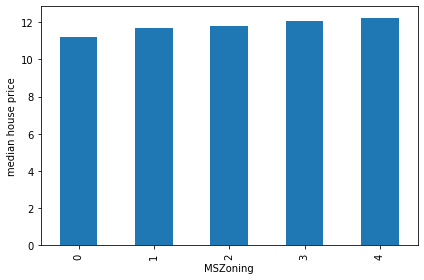

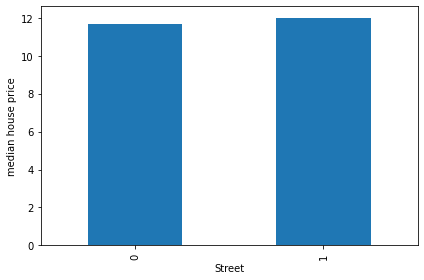

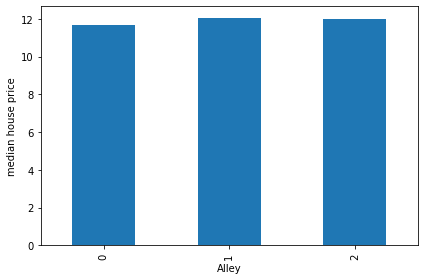

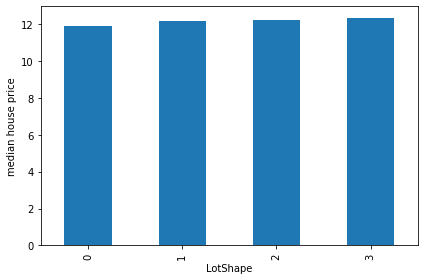

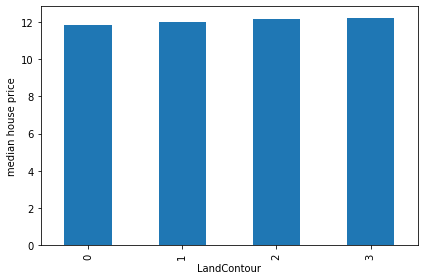

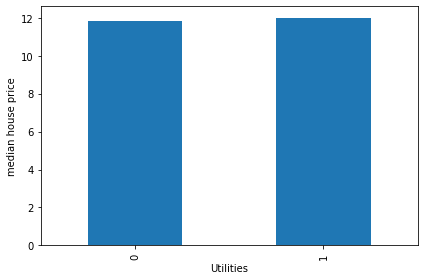

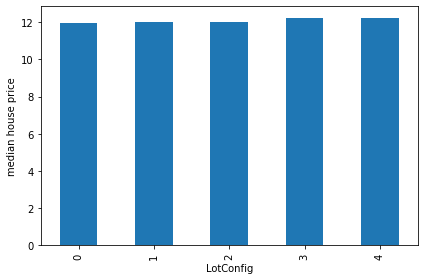

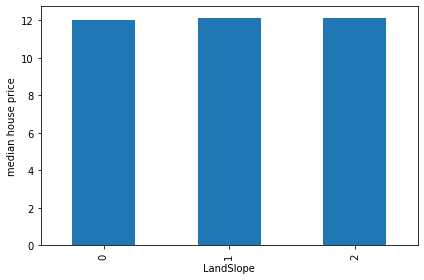

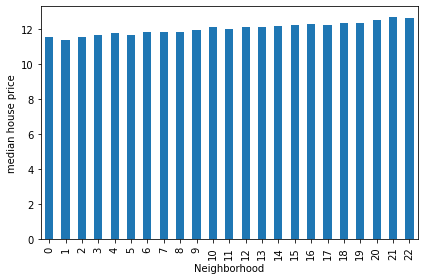

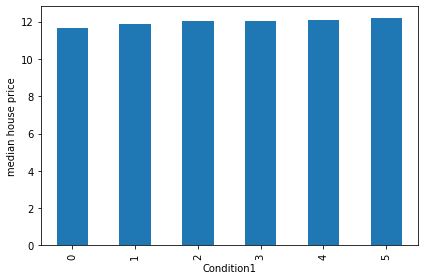

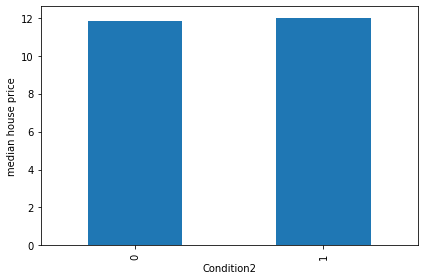

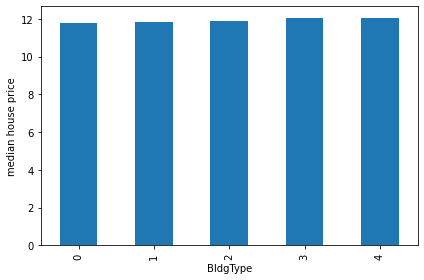

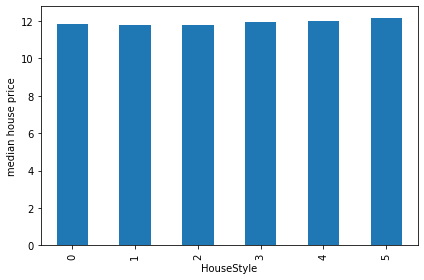

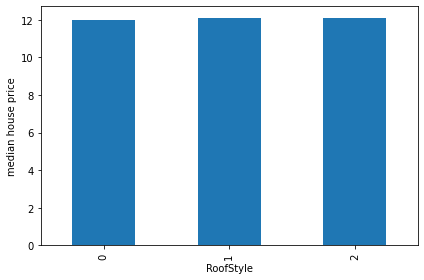

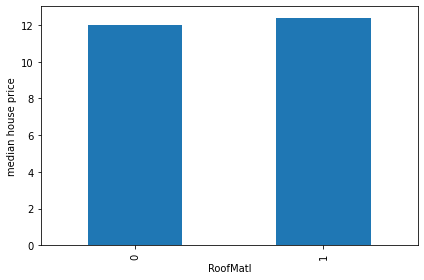

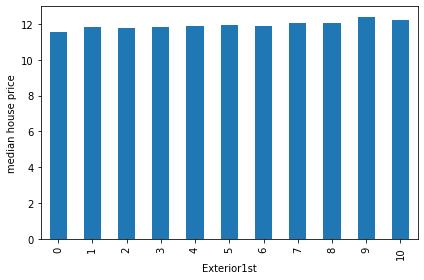

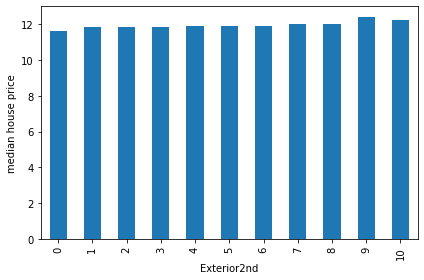

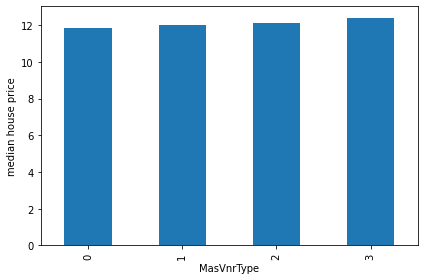

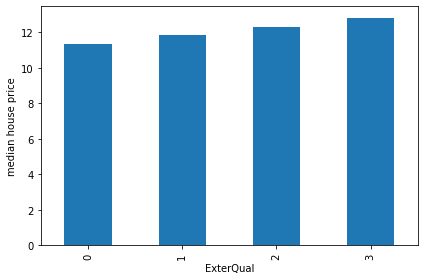

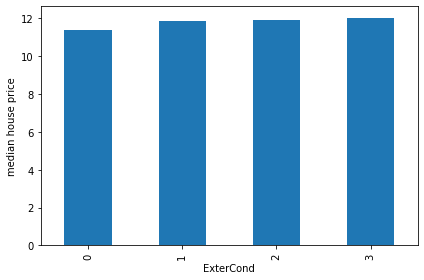

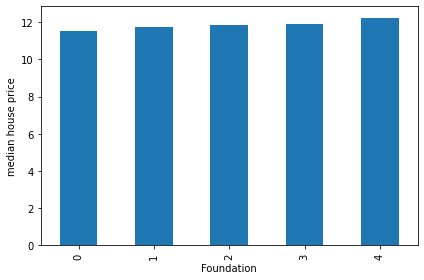

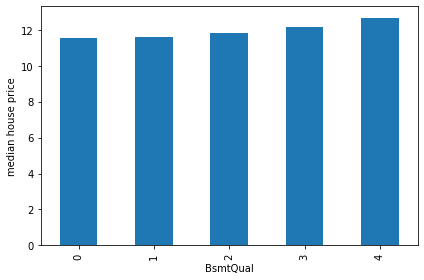

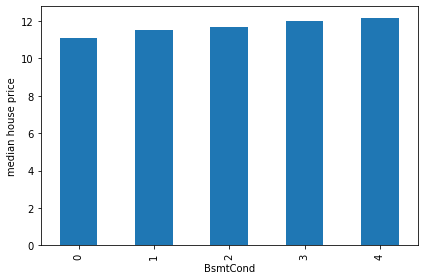

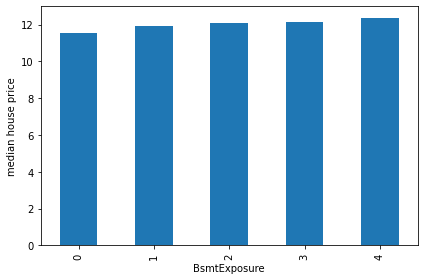

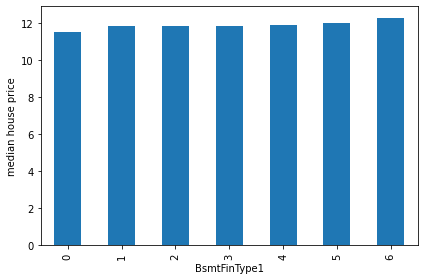

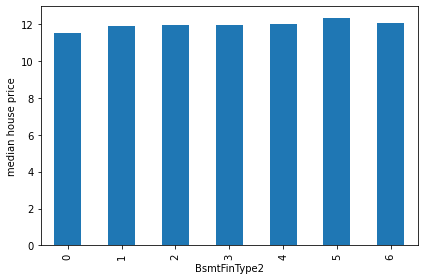

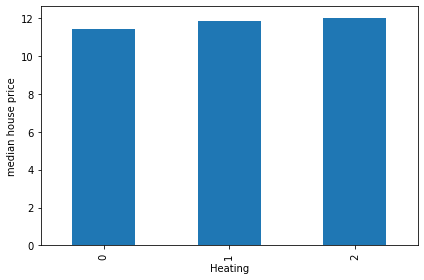

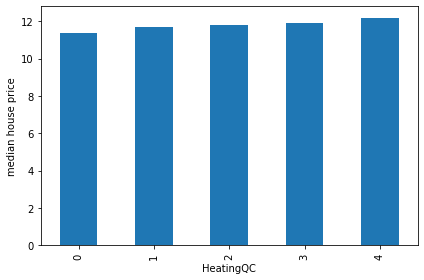

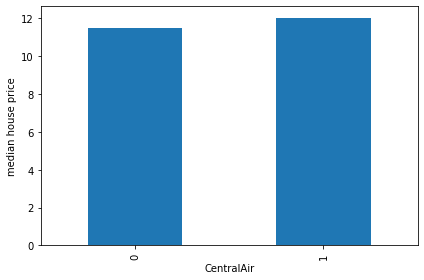

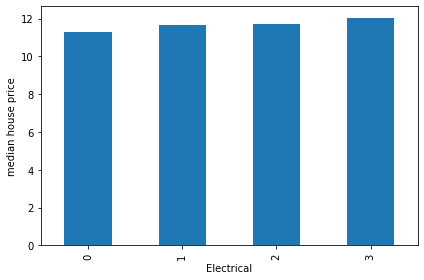

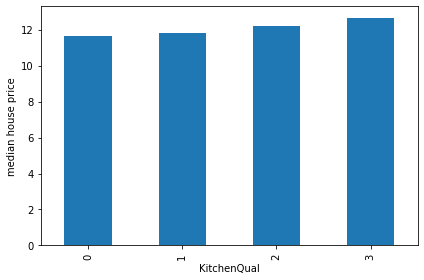

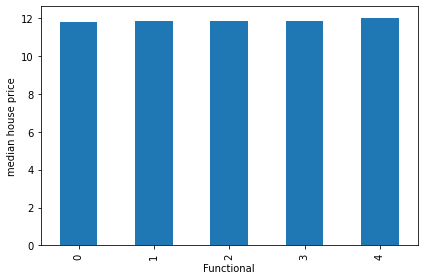

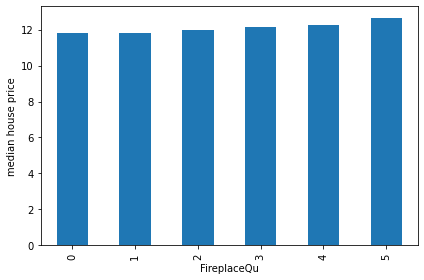

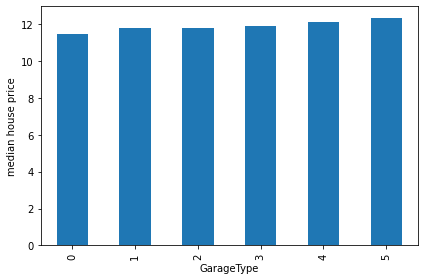

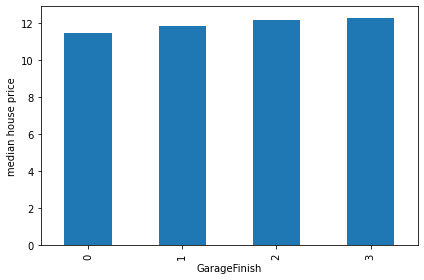

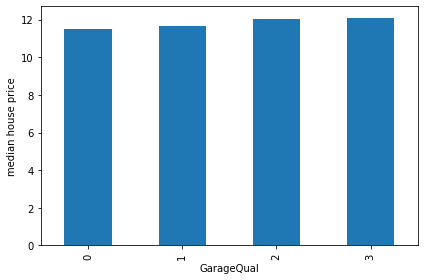

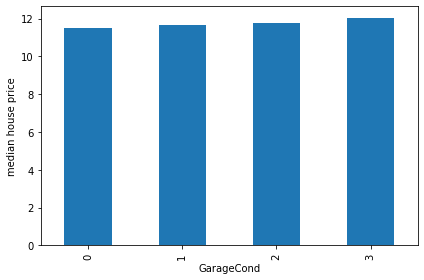

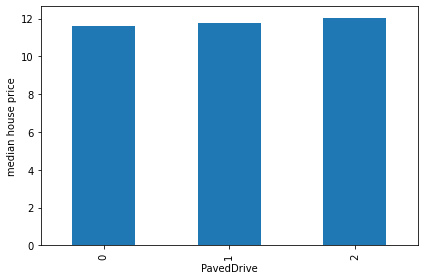

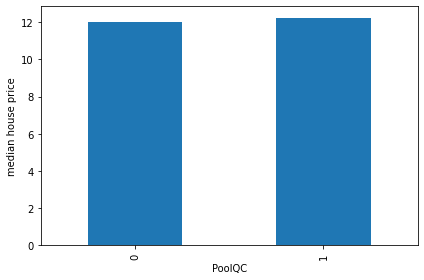

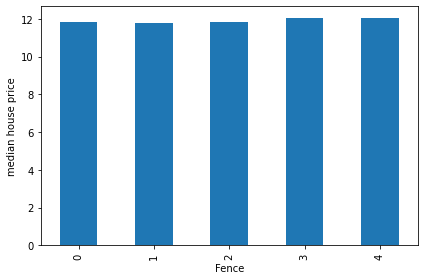

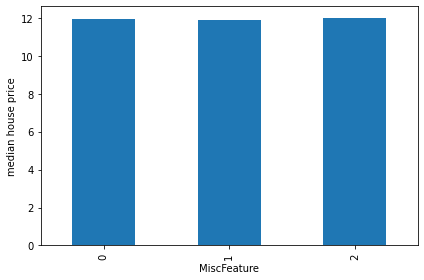

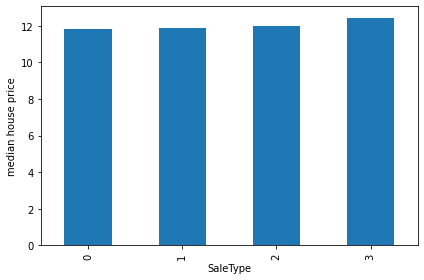

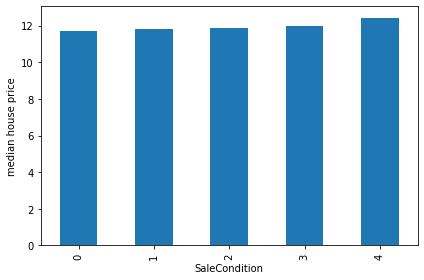

In [52]:
for var in cat_vars:
    analyze_vars(X_train, var)

In [53]:
train_vars = [var for var in X_train.columns if var not in ['Id', 'SalePrice']]
len(train_vars)

82

In [54]:
X_train[['Id', 'SalePrice']].reset_index(drop = True)

,Id,SalePrice
0,931,12.211060
1,657,11.887931
2,46,12.675764
3,1349,12.278393
4,56,12.103486
5,1229,12.813918
6,964,12.384219
7,922,11.890677
8,459,11.989160
9,1387,12.429216


In [57]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()
scalar.fit(X_train[train_vars])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [60]:
X_train = pd.concat([X_train[['Id', 'SalePrice']].reset_index(drop = True), pd.DataFrame(scalar.transform(X_train[train_vars]), columns = train_vars)], axis = 1)

X_test = pd.concat([X_test[['Id', 'SalePrice']].reset_index(drop = True), pd.DataFrame(scalar.transform(X_test[train_vars]), columns = train_vars)], axis = 1)

In [61]:
X_train.head()

,Id,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,931,12.211060,0.000000,0.75,0.461171,0.377048,1.0,1.0,0.333333,1.000000,1.0,0.0,0.0,0.863636,0.4,1.0,0.75,0.6,0.777778,0.50,0.014706,0.049180,0.0,0.0,1.0,1.0,0.000000,0.00000,0.666667,1.0,1.0,0.75,0.75,0.75,1.000000,0.002835,0.666667,0.0,0.673479,0.239935,1.0,1.00,1.0,1.0,0.559760,0.0,0.0,0.523250,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.416667,1.0,0.000000,0.2,0.8,0.018692,1.000000,0.75,0.430183,0.666667,1.0,1.0,0.116686,0.032907,0.0,0.000000,0.0,0.0,0.0,0.75,1.0,0.0,0.545455,0.75,0.666667,0.75,0.0,0.0,0.0
1,657,11.887931,0.000000,0.75,0.456066,0.399443,1.0,1.0,0.333333,0.333333,1.0,0.0,0.0,0.363636,0.4,1.0,0.75,0.6,0.444444,0.75,0.360294,0.049180,0.0,0.0,0.6,0.6,0.666667,0.03375,0.666667,1.0,0.5,0.50,0.75,0.25,0.666667,0.142807,0.666667,0.0,0.114724,0.172340,1.0,1.00,1.0,1.0,0.434539,0.0,0.0,0.406196,0.333333,0.0,0.333333,0.5,0.375,0.333333,0.666667,0.250000,1.0,0.000000,0.2,0.8,0.457944,0.666667,0.25,0.220028,0.666667,1.0,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.50,1.0,0.0,0.636364,0.50,0.666667,0.75,0.0,0.0,0.0
2,46,12.675764,0.588235,0.75,0.394699,0.347082,1.0,1.0,0.000000,0.333333,1.0,0.0,0.0,0.954545,0.4,1.0,1.00,0.6,0.888889,0.50,0.036765,0.098361,1.0,0.0,0.3,0.2,0.666667,0.25750,1.000000,1.0,1.0,1.00,0.75,0.25,1.000000,0.080794,0.666667,0.0,0.601951,0.286743,1.0,1.00,1.0,1.0,0.627205,0.0,0.0,0.586296,0.333333,0.0,0.666667,0.0,0.250,0.333333,1.000000,0.333333,1.0,0.333333,0.8,0.8,0.046729,0.666667,0.50,0.406206,0.666667,1.0,1.0,0.228705,0.149909,0.0,0.000000,0.0,0.0,0.0,0.75,1.0,0.0,0.090909,1.00,0.666667,0.75,0.0,0.0,0.0
3,1349,12.278393,0.000000,0.75,0.388581,0.493677,1.0,1.0,0.666667,0.666667,1.0,0.0,0.0,0.454545,0.4,1.0,0.75,0.6,0.666667,0.50,0.066176,0.163934,0.0,0.0,1.0,1.0,0.000000,0.00000,0.666667,1.0,1.0,0.75,0.75,1.00,1.000000,0.255670,0.666667,0.0,0.018114,0.242553,1.0,1.00,1.0,1.0,0.566920,0.0,0.0,0.529943,0.333333,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.250000,1.0,0.333333,0.4,0.8,0.084112,0.666667,0.50,0.362482,0.666667,1.0,1.0,0.469078,0.045704,0.0,0.000000,0.0,0.0,0.0,0.75,1.0,0.0,0.636364,0.25,0.666667,0.75,1.0,0.0,0.0
4,56,12.103486,0.000000,0.75,0.577658,0.402702,1.0,1.0,0.333333,0.333333,1.0,0.0,0.0,0.363636,0.4,1.0,0.75,0.6,0.555556,0.50,0.323529,0.737705,0.0,0.0,0.6,0.7,0.666667,0.17000,0.333333,1.0,0.5,0.50,0.75,0.25,0.333333,0.086818,0.666667,0.0,0.434278,0.233224,1.0,0.75,1.0,1.0,0.549026,0.0,0.0,0.513216,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.333333,0.416667,1.0,0.333333,0.8,0.8,0.411215,0.666667,0.50,0.406206,0.666667,1.0,1.0,0.000000,0.000000,0.0,0.801181,0.0,0.0,0.0,0.75,1.0,0.0,0.545455,0.50,0.666667,0.75,0.0,0.0,0.0


In [63]:
X_train.to_csv(os.path.join(config['PATH']['DATA_PATH'], 'X_train.csv'), index = False)
X_test.to_csv(os.path.join(config['PATH']['DATA_PATH'], 'X_test.csv'), index = False)